In [883]:
%pylab inline
%run ../../figures/params.py

import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

features = ['uninterrupted_length', 'gc', 'recomb', 'reptiming','p2', 'p4','entropy']


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [873]:
# Load parameters
params = {}
with open("params.sh", "r") as f:
    for line in f:
        if "=" not in line: continue
        key, val = line.strip().split("=")
        params[key] = val

In [874]:
#params["BASEDIR"] = "~/Downloads"# TODO remove
#params["PREDFILE"] = os.path.join("/Users/gymrek/Downloads/", "constraint","autosomal_perlocus_estimates.bed")

In [884]:
datafile = os.path.join(params["BASEDIR"], "constraint","autosomal_perlocus_train_intergenic.bed.gz")
dataset = pd.read_csv(datafile, sep="\t").drop_duplicates()
dataset["ml_mu_stderr_adj"] = dataset.apply(lambda x: x["ml_mu_stderr"]/abs(x["ml_mu"]), 1)

# Set new features
dataset['period'] = dataset['motif'].str.len()
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)

# Restrict to di, tri, tetra
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
dataset = dataset[~dataset["featurefilter"]]


In [880]:
def CenterData(data):
    df = pd.DataFrame({"data": data, "ind": range(data.shape[0])})
    df = df.sort("data")
    vals = np.random.normal(size=data.shape[0])
    vals = sorted(vals)
    df["norm"] = vals
    df = df.sort("ind")
    return df["norm"]

def SetFilter(df):
    df["filter"] = False
    df.ix[(df["ml_mu_stderr_adj"]<=0) | (df["ml_mu_stderr_adj"]>=0.10), "filter"] = True

0.400706002205
(0.74050950895539913, 0.0)
(0.64113651101813085, 0.0)


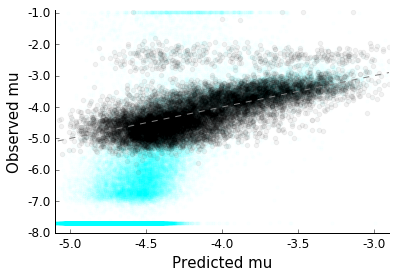

In [885]:
##################
# Linear Regression
##################

filtercolor = "cyan"
keepcolor = "black"

# Set filter field
SetFilter(dataset)

# Center data (not length and period)
for f in ["gc","entropy","recomb","reptiming"]:
    dataset[f] = CenterData(dataset[f])

# Split data to train and test
base_X = dataset[features] #pd.get_dummies(dataset[features], prefix="motif")
base_y = dataset['ml_mu']
base_filter = dataset["filter"]
base_weights = dataset["ml_mu_stderr_adj"].apply(lambda x: 1.0/(x**2))
train_X, test_X, \
    train_y, test_y, \
    train_filter, test_filter, \
    train_weights, test_weights = xval.train_test_split(base_X, base_y, base_filter, base_weights, test_size=0.25)
y_colors = test_filter.apply(lambda x: [keepcolor, filtercolor][int(x)])

# Filter training data
train_X = train_X[~train_filter]
train_y = train_y[~train_filter]
train_weights = train_weights[~train_filter]

# Build linear regression model
train_X_sm = sm.add_constant(train_X)
model = sm.WLS(train_y, train_X_sm, weights=train_weights)
smols = model.fit()
pred_y = smols.predict(sm.add_constant(test_X))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pred_y[y_colors.values==filtercolor], test_y[y_colors.values==filtercolor], alpha=0.01, color=filtercolor, s=10)
ax.scatter(pred_y[y_colors.values==keepcolor], test_y[y_colors.values==keepcolor], alpha=0.05, color=keepcolor)
plt.plot([-7, -2],[-7,-2], color="gray", linestyle="dashed")
ax.set_xlim(left=-5.1, right=-2.9)
ax.set_ylim(bottom=-8, top=-0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted mu", size=15)
ax.set_ylabel("Observed mu", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modeleval.pdf"))

print smols.rsquared_adj
print pearsonr(pred_y, test_y)
print pearsonr(pred_y[~test_filter.values], test_y[~test_filter.values])

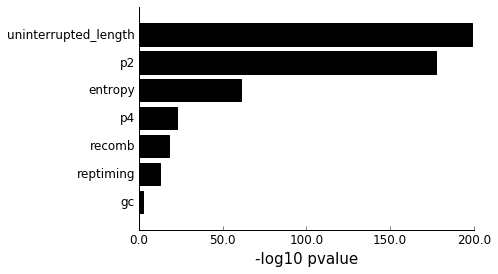

In [877]:
mparams = pd.DataFrame({"feature": smols.params.index, "coeff": smols.params, "pval": smols.pvalues})
mparams["log10p"] = -1*np.log10(mparams["pval"]+10e-200)
mparams = mparams[mparams["feature"] != "const"]
mparams = mparams.sort("pval", ascending=False)
ind = range(1, mparams.shape[0]+1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(ind, mparams["log10p"], align="center", color="black")
ax.set_yticks(ind);
ax.set_yticklabels(mparams.feature);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("-log10 pvalue", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticklabels(), size=12);
fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modelparams.pdf"))

In [887]:
##################
# Predict
##################

# Load data
datafile = os.path.join(params["BASEDIR"], "constraint","autosomal_perlocus_observed.bed")
dataset = pd.read_csv(datafile, sep="\t").drop_duplicates()

# Load extra features
dataset["period"] = dataset["motif"].apply(len)
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)
dataset["ml_mu_stderr_adj"] = dataset.apply(lambda x: x["ml_mu_stderr"]/abs(x["ml_mu"]), 1)

# Filter
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
SetFilter(dataset)

# Predict and save
header = ['chrom','start','end','ml_mu','ml_mu_stderr','motif','pred_mu','pred_mu_se','filter']
dataset['pred_mu'] = smols.predict(sm.add_constant(dataset[features]))
dataset['pred_mu_se'] = wls_prediction_std(smols, sm.add_constant(dataset[features]))[0]
dataset[header].to_csv(params["PREDFILE"], columns=header, index=False, compression="gzip")